# Supervised Learning II – Klassifikation mit Logistischer Regression

## Lernziele

Am Ende dieses Notebooks kannst du:

* den Unterschied zwischen Regressions- und Klassifikationsproblemen erklären,
* Klassifikationsmodelle mit Scikit-learn trainieren und bewerten,
* die logistische Regression auf geeignete Probleme anwenden und
* gängige Metriken zur Evaluation von Klassifikationsmodellen interpretieren.

# Logistische Regression

## Das Modell - Die Sigmoid-Funktion

## Die Verlustfunktion - Cross-Entropy

## Die Minimierung des Fehlers

# Hands-On: Logistische Regression für TODO

## Inspektion

## Preprocessing

## Klassifikation

## Evaluation des Modells

### 1. Accuracy

### 2. Precision

### 3. Recall

### 4. F1

### 5. Weitere Metriken

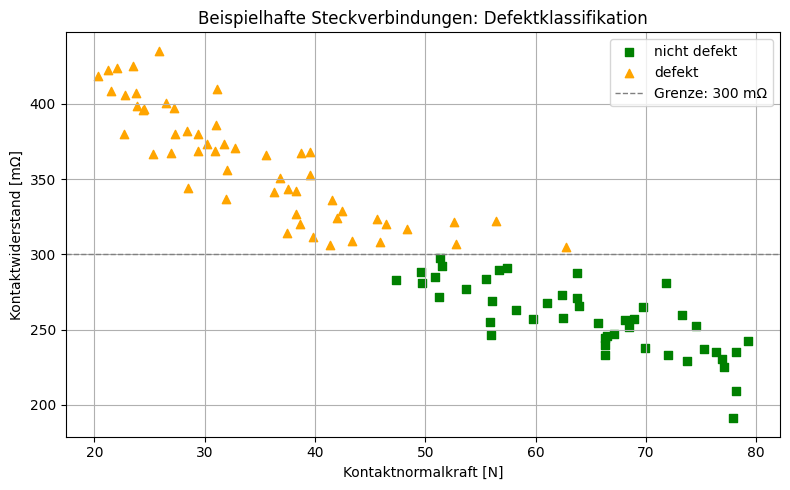

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../Data/classification_data_resistance_force.csv')

force = data['Normalkraft']
resistance = data['Widerstand']
is_defective = resistance > 300

fig, ax = plt.subplots(figsize= (8,5))
ax.scatter(force[~is_defective], resistance[~is_defective],
            c='green', marker='s', label='nicht defekt')
ax.scatter(force[is_defective], resistance[is_defective],
            c='orange', marker='^', label='defekt')
ax.axhline(300, color='gray', linestyle='--', linewidth=1, label='Grenze: 300 mΩ')

plt.xlabel("Kontaktnormalkraft [N]")
plt.ylabel("Kontaktwiderstand [mΩ]")
plt.title("Defektklassifikation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()